전처리

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. 데이터 로드
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA/train_titanic.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA/test_titanic.csv') # 원본 보존용
X_test_passengers = X_test['PassengerId']

# 2. Title(호칭) 추출 및 통합
def get_title(df):
    titles = [i.split(',')[1].split('.')[0].strip() for i in df['Name']]
    df['Title'] = pd.Series(titles)
    df['Title'] = df['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Ms', 'Mme', 'Mlle'], 'Rare')
    return df

dataset = get_title(dataset)
X_test = get_title(X_test.copy())

# 3. FamilySize 및 IsAlone 생성
for df in [dataset, X_test]:
    df['FamilyS'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilyS'] == 1).astype(int)
    # 가족 규모 그룹화 (1:혼자, 2~4:적당함, 5+:많음)
    df['FamilyS'] = df['FamilyS'].apply(lambda x: 0 if x == 1 else (1 if x <= 4 else 2))

# 4. 결측치 채우기 (학습 데이터 기준 적용)
age_medians = dataset.groupby("Title")["Age"].median()
embarked_mode = dataset['Embarked'].mode()[0]
fare_medians = dataset.groupby('Pclass')['Fare'].median()

for df in [dataset, X_test]:
    df['Age'] = df['Age'].fillna(df['Title'].map(age_medians))
    df['Age'] = df['Age'].fillna(dataset['Age'].median()) # 안전장치
    df['Embarked'] = df['Embarked'].fillna(embarked_mode)
    df['Fare'] = df['Fare'].fillna(df['Pclass'].map(age_medians))
    df['Fare'] = df['Fare'].fillna(dataset['Fare'].median())

# 5. Fare & Age 구간 나누기 (Binning) - 무한대 범위 확장으로 에러 방지
fare_bins = [-np.inf, 20, 40, 100, np.inf]

age_bins =  [-np.inf, 7, 21, 34, 55, np.inf]

for df in [dataset, X_test]:
    df['Fare'] = pd.cut(df['Fare'], bins=fare_bins, labels=[0, 1, 2, 3], include_lowest=True).astype(int)
    df['Age'] = pd.cut(df['Age'], bins=age_bins, labels=[0, 1, 2, 3, 4], include_lowest=True).astype(int)

# 6. 학습에 사용할 피처 선택 (에러 방지를 위해 명시적 지정)
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilyS', 'IsAlone']
X_train = dataset[features].values
Y_train = dataset['Survived'].values
X_test = X_test[features].values

# 7. Label Encoding (Sex=1, Embarked=4, Title=5)
for i in [1, 4, 5]:
    le = LabelEncoder()
    X_train[:, i] = le.fit_transform(X_train[:, i])
    X_test[:, i] = le.transform(X_test[:, i])

# 8. ColumnTransformer & OneHotEncoding
# 모든 피처를 범주형으로 취급하여 처리 (sparse_output=False로 toarray 불필요하게 설정)
ct = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), list(range(len(features))))
    ],
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train).astype(np.float32)
X_test = ct.transform(X_test).astype(np.float32)

<Axes: xlabel='Age', ylabel='Count'>

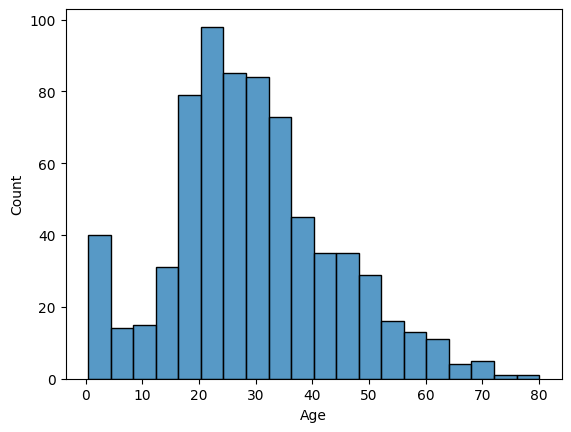

In [24]:
import seaborn as sns

dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA/train_titanic.csv')
sns.histplot(dataset['Age'])

In [25]:
#트레이닝

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn.utils import shuffle
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import random

def set_seed(seed=55):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(55)

input_size = X_train.shape[1]

# nn->76076
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.layer(x)

net = Net(input_size)

batch_size = 64
num_epochs = 80
learning_rate = 0.0005

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

g = torch.Generator()
g.manual_seed(55)
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(Y_train))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=g)

for epoch in range(num_epochs):
    net.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = net(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/80], Loss: 0.3545
Epoch [20/80], Loss: 0.3707
Epoch [30/80], Loss: 0.5262
Epoch [40/80], Loss: 0.4418
Epoch [50/80], Loss: 0.2927
Epoch [60/80], Loss: 0.2648
Epoch [70/80], Loss: 0.3083
Epoch [80/80], Loss: 0.2847


In [28]:
net.eval()

with torch.no_grad():
    test_inputs = torch.FloatTensor(X_test)
    test_outputs = net(test_inputs)

    _, test_preds = torch.max(test_outputs, 1)
    survived = test_preds.numpy()

    nn_probs = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
print("예측이 완료되었습니다.")
import csv

submission = [['PassengerId', 'Survived']]
for i in range(len(survived)):
    submission.append([X_test_passengers[i], survived[i]])

with open('submission_nn.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerows(submission)

print('Writing Complete!')

예측이 완료되었습니다.
Writing Complete!


랜덤포레스트 & XGBoost


In [29]:
#트레이닝

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=55,
    n_jobs=-1
    )

rf_model.fit(X_train, Y_train)

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma = 1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=55
)
# estimator 100, learningrate 0.05에서 낮췄더니 0.76315 -> 0.7799
xgb_model.fit(X_train, Y_train)



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:21:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [32]:
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]


#앙상블, 랜덤포레스트, XGBoost
xgb_rf_labels = (((rf_probs * 0.5) + (xgb_probs * 0.5)) > 0.5).astype(int)
xgb_rf_nn_labels = ((rf_probs * 0.3) + (xgb_probs * 0.5) + (nn_probs * 0.2) > 0.5).astype(int)
rf_labels = (rf_probs > 0.5).astype(int)
xgb_labels = (xgb_probs > 0.5).astype(int)


test

In [33]:
import csv

def save_submission(preds, name):
    submission = pd.DataFrame({
        "PassengerId": X_test_passengers,
        "Survived": preds.astype(int)
    })
    submission.to_csv(f'submission_{name}.csv', index=False)
    print(f'Saved: submission_{name}.csv')

save_submission(xgb_rf_labels, 'xgb_rf')
save_submission(xgb_rf_nn_labels, 'xgb_rf_nn')
save_submission(rf_labels, 'rf')
save_submission(xgb_labels, 'xgb')

#xgb -> 0.77033
#rf -> 0.77511
#xgb_rf -> 0.78708
#xgb_rf_nn -> 77511

Saved: submission_xgb_rf.csv
Saved: submission_xgb_rf_nn.csv
Saved: submission_rf.csv
Saved: submission_xgb.csv
